# Fees and margins

This notebook looks into fees (modelling a single market maker) and margins required to fullfil the market making obligation. Please [here](liquidity_reward_distribution.ipynb) for details of liquidity fee split when multiple market makers support a market. 

In [1]:
import numpy as np
import pandas as pd
import time


import _sim
from mechanism import *
from _utils import *
from IPython.display import Markdown as md

import math

In [2]:
# Set-up constants and helper functions

N_DAYS = 200
PARAM_K = 2

def get_example_market(initial_mark_price,volume,open_interest,tick_size=0.01,num_ticks=10):
    mkt = Market(
        name='Example market', 
        mark_price=initial_mark_price,
        traded_volume=volume, 
        open_interest=open_interest, 
        tick_size=tick_size, 
        num_ticks=num_ticks,
        liquidity=Liquidity(c2=1.2, v=5, k=PARAM_K),
        risk_model=RiskModel(mu=0.0, sigma=2.0, tau=1.0/60/24/365.25, lambd=0.001))
    return mkt

## Fees 
Let's start by looking into the components of the amount of fees collected from the market each day. Please note we only consider the `liquidity fees` in this example. Other fees include: `maker fee` - fee paid to the party whose limit order is already on the book and gets matched to an incomming order - and `infrastructure fees` - fees paid to node operators - are outside of the scope of this notebook. Furthermore, we concentrate on a single market maker who effectively gets to set the `liquidity fee` level. 

In [3]:
constant_mark_price = 100
constant_volume = 1e6
constant_OI = 0.25*constant_volume
constant_fee_level = 0.0025

In [4]:
md(f"### Everything constant\n \
Let's set-up the simplest possible example where price, daily volume and fee level are all constant.<br> \
We use `traded_volume`={constant_volume}, `fee_level`={constant_fee_level}.<br> \
Then `daily_collected_fees`=`traded_volume`\*`fee_level`={constant_volume*constant_fee_level}. <br> <br> \
Please note that `traded_volume` stands for the notional value traded in the market on a given day.")

### Everything constant
 Let's set-up the simplest possible example where price, daily volume and fee level are all constant.<br> We use `traded_volume`=1000000.0, `fee_level`=0.0025.<br> Then `daily_collected_fees`=`traded_volume`\*`fee_level`=2500.0. <br> <br> Please note that `traded_volume` stands for the notional value traded in the market on a given day.

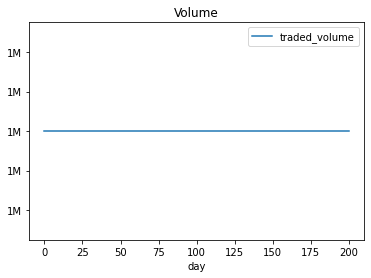

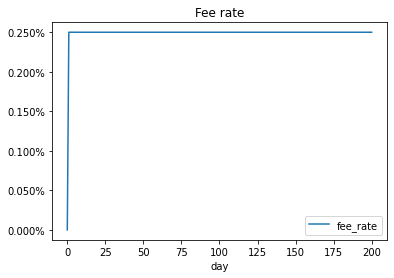

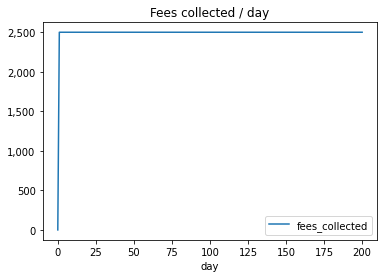

In [5]:
example_market = get_example_market(constant_mark_price, constant_volume, constant_OI)

# Entry format = (day_N, mm_name, stake, fee_bid)
commitments = sorted([  
    (1, 'A', 100000, constant_fee_level, None, None)
], key=lambda x: x[0])

for i in range(N_DAYS):
    while commitments and commitments[0][0] <= i:
        (_, lp_name, stake, fee_bid, sell_side_shape, buy_side_shape) = commitments.pop(0)
        lp=LiquidityProvider(example_market, name=lp_name, stake=stake, fee_bid=fee_bid)
    example_market=example_market.next()  

plots(example_market,traded_volume=True,fee_rate=True,fees_collected=True)

In [6]:
md(f"### Varying volume\n \
Now let the volume increase linearly so that it doubles over the course of market's life and see how it impacts collected fees.")

### Varying volume
 Now let the volume increase linearly so that it doubles over the course of market's life and see how it impacts collected fees.

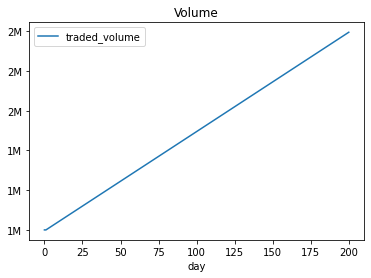

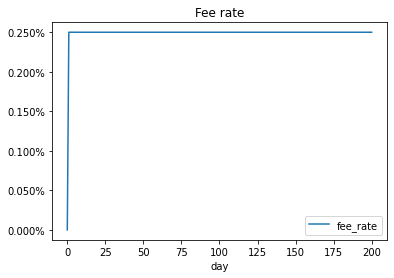

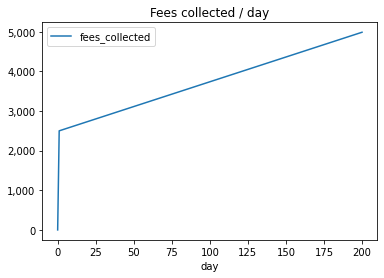

In [7]:
example_market = get_example_market(constant_mark_price, constant_volume, constant_OI)

# Entry format = (day_N, mm_name, stake, fee_bid)
commitments = sorted([  
    (1, 'A', 100000, constant_fee_level, None, None)
], key=lambda x: x[0])

for i in range(N_DAYS):
    while commitments and commitments[0][0] <= i:
        (_, lp_name, stake, fee_bid, sell_side_shape, buy_side_shape) = commitments.pop(0)
        lp=LiquidityProvider(example_market, name=lp_name, stake=stake, fee_bid=fee_bid)
    example_market=example_market.next(
        mark_price=constant_mark_price, 
        traded_volume=constant_volume+i*constant_volume/N_DAYS)  

plots(example_market,traded_volume=True,fee_rate=True,fees_collected=True)


In [8]:

md(f"#### Varying fee level\n \
Let the fee level be a step function which increases every 40 days by a it's initial level (double in 40 days, tripple in 80 etc).")

#### Varying fee level
 Let the fee level be a step function which increases every 40 days by a it's initial level (double in 40 days, tripple in 80 etc).

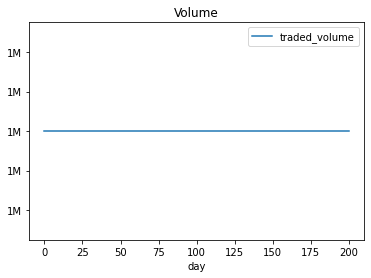

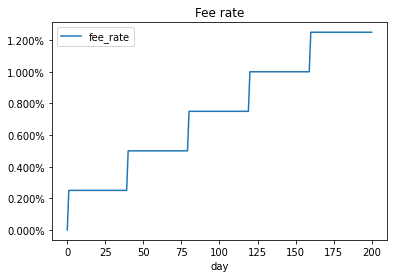

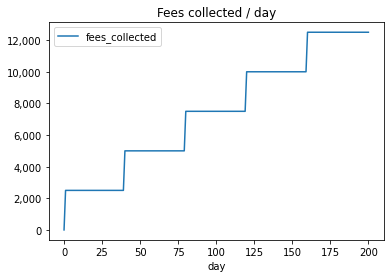

In [9]:
example_market = get_example_market(constant_mark_price, constant_volume, constant_OI)

# Entry format = (day_N, mm_name, stake, fee_bid)
commitments = sorted([  
    (1, 'A', 100000, constant_fee_level, None, None),
    (40, 'A', 100000, 2*constant_fee_level, None, None),
    (80, 'A', 100000, 3*constant_fee_level, None, None),
    (120, 'A', 100000, 4*constant_fee_level, None, None),
    (160, 'A', 100000, 5*constant_fee_level, None, None)

], key=lambda x: x[0])

for i in range(N_DAYS):
    while commitments and commitments[0][0] <= i:
        (_, lp_name, stake, fee_bid, sell_side_shape, buy_side_shape) = commitments.pop(0)
        lp=LiquidityProvider(example_market, name=lp_name, stake=stake, fee_bid=fee_bid)
    example_market=example_market.next(
        mark_price=constant_mark_price, 
        traded_volume=constant_volume)  

plots(example_market,traded_volume=True,fee_rate=True,fees_collected=True)

In [10]:
md(f"#### Varying everything at once\n \
Finally, as an experiment, let's apply both of the above variations at the same time.")

#### Varying everything at once
 Finally, as an experiment, let's apply both of the above variations at the same time.

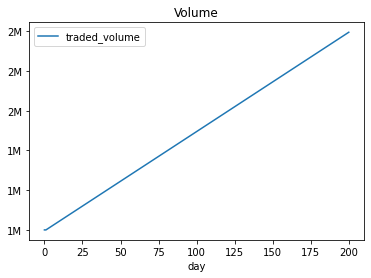

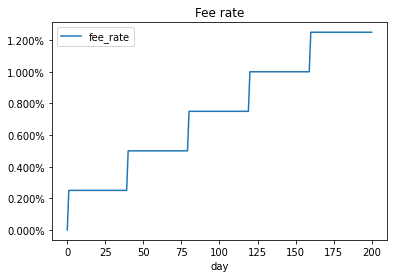

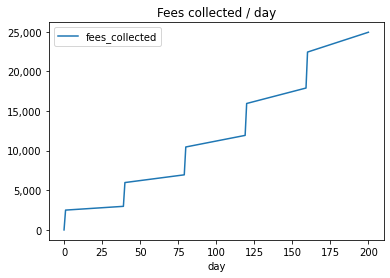

In [11]:
example_market = get_example_market(constant_mark_price, constant_volume, constant_OI)

# Entry format = (day_N, mm_name, stake, fee_bid)
commitments = sorted([  
    (1, 'A', 100000, constant_fee_level, None, None),
    (40, 'A', 100000, 2*constant_fee_level, None, None),
    (80, 'A', 100000, 3*constant_fee_level, None, None),
    (120, 'A', 100000, 4*constant_fee_level, None, None),
    (160, 'A', 100000, 5*constant_fee_level, None, None)

], key=lambda x: x[0])

for i in range(N_DAYS):
    while commitments and commitments[0][0] <= i:
        (_, lp_name, stake, fee_bid, sell_side_shape, buy_side_shape) = commitments.pop(0)
        lp=LiquidityProvider(example_market, name=lp_name, stake=stake, fee_bid=fee_bid)
    example_market=example_market.next(
        mark_price=constant_mark_price, 
        traded_volume=constant_volume+i*constant_volume/N_DAYS)  

plots(example_market,traded_volume=True,fee_rate=True,fees_collected=True)


In [12]:
stake = 100000
limit_orders_bid= [200,100,50,25,10,0,0,0,0,0]
limit_orders_offer= [300,100,50,25,10,0,0,0,0,0]
lf_bid_uniform = [1,1,1,1,1,1,1,1,1,1]
lf_offer_uniform = [1,1,1,1,1,1,1,1,1,1]

md(f"## Market maker obligations\n \
Now, let's look closer into market maker obligations, how can they be fullfiled and how are the resulting margin requirements impacted.\n\
### How is market maker obligation calculated? \n \
Each market maker is obligated to keep a specified amount of open orders on the book. The amount is a function of the stake provided:  `stake` * `k`. In this exmaple `k`:={PARAM_K}. \n \
### How can the obligation be fullfiled? \n \
The resulting obligation is compared to the probability weighted volume deployed on the order book by a given market maker. The probability is implied by the risk model used for the market. It's purpose is to approximate how useful the orders are to the market. The closer to the mid, the higher the probability of trading and hence less volume is required to fulfil a given obligation. <br> <br> \
The market maker can choose to specify the orders manually, but must also prescribe the 'shape' for pegged orders (fraction of liquidity to be deployed at different ticks). If the manually specified orders don't provide sufficient liquidity the pegged orders are automatically deployed to cover the difference. <br> <br> \
The supplied liquidity will be calculated as the min(liquidity_bid,liquidity_offer) to avoid one sided markets. Please refer to our [liquidity paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3651085) for details. The overall margin charged on open orders will be calcualted as max(margin_bid,margin_offer) as the change in mark price has opposite effects on the two sides. <br> <br> \
Let's look at an example where the market maker has commited a stake of {'{:,.0f}'.format(stake)}. The resulting obligation is: <br> \
`obligation`=`k` * `stake`={'{:,.0f}'.format(stake*PARAM_K)}. <br> \
Assume the market has only 10 price levels on each side of the book and the market maker deploys limit orders with following volumes: <br> \
bids --> {np.flip(limit_orders_bid)} | mid | {limit_orders_offer}  <-- offers <br> \
and the following shapes for the pegged orders liquidity fractions: <br> \
bids --> {np.flip(lf_bid_uniform)} | mid | {lf_offer_uniform}  <-- offers <br> <br>\
or visually:")

## Market maker obligations
 Now, let's look closer into market maker obligations, how can they be fullfiled and how are the resulting margin requirements impacted.
### How is market maker obligation calculated? 
 Each market maker is obligated to keep a specified amount of open orders on the book. The amount is a function of the stake provided:  `stake` * `k`. In this exmaple `k`:=2. 
 ### How can the obligation be fullfiled? 
 The resulting obligation is compared to the probability weighted volume deployed on the order book by a given market maker. The probability is implied by the risk model used for the market. It's purpose is to approximate how useful the orders are to the market. The closer to the mid, the higher the probability of trading and hence less volume is required to fulfil a given obligation. <br> <br> The market maker can choose to specify the orders manually, but must also prescribe the 'shape' for pegged orders (fraction of liquidity to be deployed at different ticks). If the manually specified orders don't provide sufficient liquidity the pegged orders are automatically deployed to cover the difference. <br> <br> The supplied liquidity will be calculated as the min(liquidity_bid,liquidity_offer) to avoid one sided markets. Please refer to our [liquidity paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3651085) for details. The overall margin charged on open orders will be calcualted as max(margin_bid,margin_offer) as the change in mark price has opposite effects on the two sides. <br> <br> Let's look at an example where the market maker has commited a stake of 100,000. The resulting obligation is: <br> `obligation`=`k` * `stake`=200,000. <br> Assume the market has only 10 price levels on each side of the book and the market maker deploys limit orders with following volumes: <br> bids --> [  0   0   0   0   0  10  25  50 100 200] | mid | [300, 100, 50, 25, 10, 0, 0, 0, 0, 0]  <-- offers <br> and the following shapes for the pegged orders liquidity fractions: <br> bids --> [1 1 1 1 1 1 1 1 1 1] | mid | [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  <-- offers <br> <br>or visually:

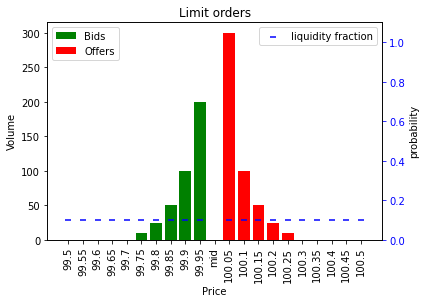

Liquidity:
	obligaton:  200,000
	bid:        14,374
	offer:      18,652
	supplied:   14,374 = min(liquidity_bid,liquidity_offer)

Margin:
	bid:         356
	offer:       452
	charged:     452 = max(margin_bid,margin_offer)


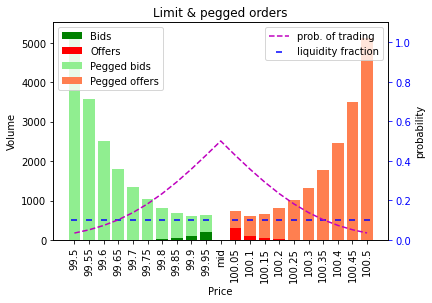

Liquidity:
	obligaton:  200,000
	bid:        200,035
	offer:      200,095
	supplied:   200,035 = min(liquidity_bid,liquidity_offer)

Margin:
	bid:         16,893
	offer:       16,748
	charged:     16,893 = max(margin_bid,margin_offer)


In [13]:
example_market = get_example_market(constant_mark_price, constant_volume, constant_OI, tick_size=0.05)

mmSellSideOrders = OrderSetForSide(
    market=example_market, 
    is_sell_side=True, 
    limit_orders=limit_orders_offer,
    liquidity_fractions=lf_offer_uniform) 
mmBuySideOrders = OrderSetForSide(
    market=example_market,
    is_sell_side=False, 
    limit_orders=limit_orders_bid,
    liquidity_fractions=lf_offer_uniform) 

lp = LiquidityProvider(example_market, name="MM", stake=stake, sell_side_shape = mmSellSideOrders, buy_side_shape = mmBuySideOrders)

visualise_orders(lp,plot_pegged_orders=False, plot_liquidity_fractions=True, plot_prob_of_trading=False, print_liquidity=True, print_margins=True, title="Limit orders")
visualise_orders(lp,plot_pegged_orders=True, plot_liquidity_fractions=True, plot_prob_of_trading=True, print_liquidity=True, print_margins=True, title="Limit & pegged orders")

In [14]:
ts = 0.01
md(f"### Relying only on order fractions\n \
Now let's see how will the orders be deployed if market maker doesn't specify any limit orders manually. We will consider 3 strategies: \n \
* Most agressive - everything deployed one tick from mid \n \
* Uniform - constant fraction across order book \n \
* Most passive - everything deployed at last tick available <br> <br> \
Note we will use a tick size of {ts} now.")

### Relying only on order fractions
 Now let's see how will the orders be deployed if market maker doesn't specify any limit orders manually. We will consider 3 strategies: 
 * Most agressive - everything deployed one tick from mid 
 * Uniform - constant fraction across order book 
 * Most passive - everything deployed at last tick available <br> <br> Note we will use a tick size of 0.01 now.

In [15]:
lo_empty = [0,0,0,0,0,0,0,0,0,0]

lf_uniform = [1,1,1,1,1,1,1,1,1,1]
lf_passive = [0,0,0,0,0,0,0,0,0,1]
lf_aggressive = [1,0,0,0,0,0,0,0,0,0]

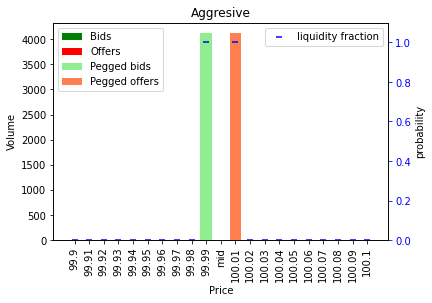

Margin:
	bid:         3,813
	offer:       3,846
	charged:     3,846 = max(margin_bid,margin_offer)


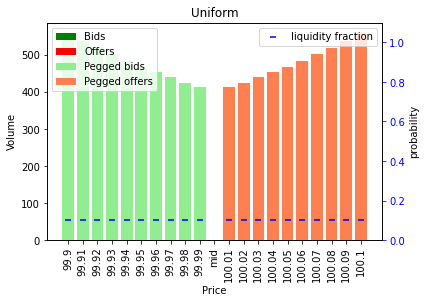

Margin:
	bid:         4,437
	offer:       4,475
	charged:     4,475 = max(margin_bid,margin_offer)


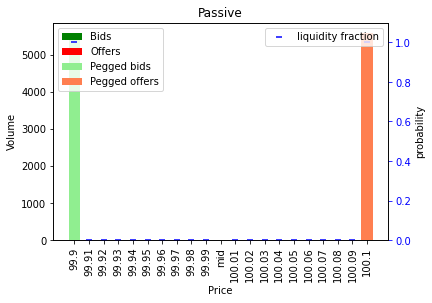

Margin:
	bid:         5,161
	offer:       5,205
	charged:     5,205 = max(margin_bid,margin_offer)


In [16]:
example_market = get_example_market(constant_mark_price, constant_volume, constant_OI, tick_size=ts)

sellSideOrdersAggressive = OrderSetForSide(
    market=example_market, 
    is_sell_side=True, 
    limit_orders=lo_empty,
    liquidity_fractions=lf_aggressive) 
buySideOrdersAggressive = OrderSetForSide(
    market=example_market,
    is_sell_side=False, 
    limit_orders=lo_empty,
    liquidity_fractions=lf_aggressive) 

lp = LiquidityProvider(example_market, name="MM", stake=stake, sell_side_shape = sellSideOrdersAggressive, buy_side_shape = buySideOrdersAggressive)

visualise_orders(lp,plot_pegged_orders=True, plot_liquidity_fractions=True, plot_prob_of_trading=False, title="Aggresive",print_margins=True)

sellSideOrdersUniform = OrderSetForSide(
    market=example_market, 
    is_sell_side=True, 
    limit_orders=lo_empty,
    liquidity_fractions=lf_uniform) 
buySideOrdersUniform = OrderSetForSide(
    market=example_market,
    is_sell_side=False, 
    limit_orders=lo_empty,
    liquidity_fractions=lf_uniform) 

lp = LiquidityProvider(example_market, name="MM", stake=stake, sell_side_shape = sellSideOrdersUniform, buy_side_shape = buySideOrdersUniform)

visualise_orders(lp,plot_pegged_orders=True, plot_liquidity_fractions=True, plot_prob_of_trading=False, title="Uniform",print_margins=True)

sellSideOrdersPassive = OrderSetForSide(
    market=example_market, 
    is_sell_side=True, 
    limit_orders=lo_empty,
    liquidity_fractions=lf_passive) 
buySideOrdersPassive = OrderSetForSide(
    market=example_market,
    is_sell_side=False, 
    limit_orders=lo_empty,
    liquidity_fractions=lf_passive) 

lp = LiquidityProvider(example_market, name="MM", stake=stake, sell_side_shape = sellSideOrdersPassive, buy_side_shape = buySideOrdersPassive)

visualise_orders(lp,plot_pegged_orders=True, plot_liquidity_fractions=True, plot_prob_of_trading=False, title="Passive",print_margins=True)

In [17]:
price_amplitude=10
price_period=100

md(f"### Margins accross time\n \
Finally, let's consider a stylised example of a market price  fluctuating around {constant_mark_price} as a sine with amplitude of {price_amplitude} and a period of {price_period}, and see how the overall margin requirements change as a function of time for the above strategies. We will consider 3 different market makers following strategies specifed above, each joining the start of the market and staking the same amount.")

### Margins accross time
 Finally, let's consider a stylised example of a market price  fluctuating around 100 as a sine with amplitude of 10 and a period of 100, and see how the overall margin requirements change as a function of time for the above strategies. We will consider 3 different market makers following strategies specifed above, each joining the start of the market and staking the same amount.

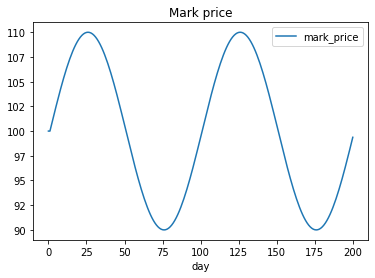

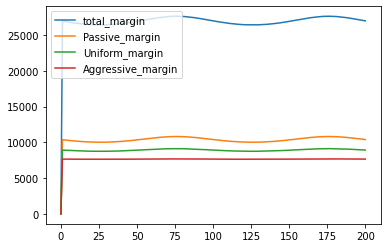

In [18]:
example_market = get_example_market(constant_mark_price, constant_volume, constant_OI)

# Market maker commitments
# Entry format = (day_N, mm_name, stake, fee_bid, buy_profile, sell_profile)
commitments = sorted([
    (1, 'Passive', stake, constant_fee_level, sellSideOrdersPassive, buySideOrdersPassive),
    (1, 'Uniform', stake, constant_fee_level, sellSideOrdersUniform, buySideOrdersUniform),
    (1, 'Aggressive', stake, constant_fee_level, sellSideOrdersAggressive, buySideOrdersAggressive)
], key=lambda x: x[0])

for i in range(N_DAYS):
    while commitments and commitments[0][0] <= i:
        (_, lp_name, stake, fee_bid, sell_side_shape, buy_side_shape) = commitments.pop(0)
        lp=LiquidityProvider(example_market, name=lp_name, stake=stake, fee_bid=fee_bid, sell_side_shape=sell_side_shape, buy_side_shape=buy_side_shape)
    example_market=example_market.next(
        mark_price=constant_mark_price+price_amplitude*math.sin(i * math.pi / (price_period / 2)), 
        traded_volume=constant_volume)  

plots(example_market,mark_price=True,margin=True)

As exptected, the passive strategy requires the most margin, while the aggressive one is the cheapest. Please note the above model only deals with the margin required to keep the orders open, it doesn't simulate orders getting filled. Once the order fills it's margin requirement will increase to account for slippage component and a the open orders will get adjusted accordingly so that the liquidity obligation is still being met. Hence, the overal margin requirement depends on the details of market making strategy. 

Please refer to [docs](https://docs.testnet.vega.xyz/docs/trading-questions/#what-happens-to-margin-when-a-trader-puts-a-trade-on) for margin calculation details - you should have recevied password during your testnet onboarding session.

### Required margin as a function of price

Let's finish by exploring the margin requirements as a function of mark price for the stragegy defined below keeping the risk model constant - though please note that different markets will use different models, depending on their properties.

In [19]:
limit_orders_bid = [0,0,0,0,0,0,0,0,0,0]
limit_orders_offer = [0,0,0,0,0,0,0,0,0,0]
lf_bid = [1,1,1,1,1,1,1,1,1,1]
lf_offer = [1,1,1,1,1,1,1,1,1,1]

def plot_per_mark_price(mark_price):
    example_market = get_example_market(mark_price, constant_volume, constant_OI, tick_size=ts)

    sellSide = OrderSetForSide(
        market=example_market, 
        is_sell_side=True, 
        limit_orders=limit_orders_offer,
        liquidity_fractions=lf_offer) 
    buySide = OrderSetForSide(
        market=example_market,
        is_sell_side=False, 
        limit_orders=limit_orders_bid,
        liquidity_fractions=lf_bid) 

    lp = LiquidityProvider(example_market, name="MM", stake=stake, sell_side_shape = sellSide, buy_side_shape = buySide)

    visualise_orders(lp,plot_pegged_orders=True, plot_liquidity_fractions=True, plot_prob_of_trading=True,print_margins=True)

from ipywidgets import interact, widgets
interact(plot_per_mark_price, mark_price=widgets.IntSlider(min=10, max=1000, step=1, value=100));

interactive(children=(IntSlider(value=100, description='mark_price', max=1000, min=10), Output()), _dom_classe…